# Кластеризация. Предобработка и обучение с частичным привлечением учителя


<hr>

С.Ю. Папулин (papulin.study@yandex.ru)

### Содержание

- [Предобработка](#Предобработка)
- [Обучение с частичным привлечением учителя](#Обучение-с-частичным-привлечением-учителя)
- [Источники](#Источники)

Подключение библиотек:

In [12]:
import time
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [13]:
from sklearn.svm import SVC
from sklearn.cluster import KMeans
from sklearn.pipeline import Pipeline

Функция загрузки исходного набора данных

In [2]:
"""
Fashion MNIST Dataset: https://github.com/zalandoresearch/fashion-mnist
"""

from os import makedirs, remove
from os.path import exists, join
import gzip

from sklearn.datasets.base import RemoteFileMetadata, _fetch_remote
from sklearn.datasets import get_data_home
from sklearn.utils import Bunch

import numpy as np
import logging


logger = logging.getLogger(__name__)


ARCHIVES = [
    RemoteFileMetadata(
        filename='train-images-idx3-ubyte.gz',
        url='http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/train-images-idx3-ubyte.gz',
        checksum=('3aede38d61863908ad78613f6a32ed271626dd12800ba2636569512369268a84')),
    RemoteFileMetadata(
        filename='train-labels-idx1-ubyte.gz',
        url='http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/train-labels-idx1-ubyte.gz',
        checksum=('a04f17134ac03560a47e3764e11b92fc97de4d1bfaf8ba1a3aa29af54cc90845')),
    RemoteFileMetadata(
        filename='test-images-idx3-ubyte.gz',
        url='http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/t10k-images-idx3-ubyte.gz',
        checksum=('346e55b948d973a97e58d2351dde16a484bd415d4595297633bb08f03db6a073')),
    RemoteFileMetadata(
        filename='test-labels-idx1-ubyte.gz',
        url='http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/t10k-labels-idx1-ubyte.gz',
        checksum=('67da17c76eaffca5446c3361aaab5c3cd6d1c2608764d35dfb1850b086bf8dd5'))
]


def fetch_fashion_mnist(data_home=None, download_if_missing=True, subset='all', return_X_y=False):  
    """
    Load the Fashion MNIST dataset (classification).
    
    Note: Based on https://github.com/scikit-learn/scikit-learn
    """
    data_home = get_data_home(data_home=data_home)
    if not exists(data_home):
        makedirs(data_home)

    for archive in ARCHIVES:
        filepath = join(data_home, archive.filename)
        if not exists(filepath):
            if not download_if_missing:
                raise IOError("Data not found and `download_if_missing` is False")
            logger.info('Downloading Fashion mnist from {} to {}'.format(
                archive.url, filepath))
            archive_path = _fetch_remote(archive, dirname=data_home)
        
    if return_X_y:
        
        DESCR = '''
            Fashion-MNIST is a dataset of Zalando's article images—consisting of 
            a training set of 60,000 examples and a test set of 10,000 examples. 
            Each example is a 28x28 grayscale image, associated with a label from 
            10 classes. We intend Fashion-MNIST to serve as a direct drop-in 
            replacement for the original MNIST dataset for benchmarking machine 
            learning algorithms. It shares the same image size and structure of 
            training and testing splits.
            '''
        
        feature_names = [
            'T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 
            'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot'
        ]
        
        
        if subset == 'train':
            X, y = _load_X_y(data_home, 'train')
            return Bunch(
                data=X,
                target=y,
                feature_names=feature_names,
                DESCR=DESCR
            )
        elif subset == 'test':
            X, y = _load_X_y(data_home, 'test')
            return Bunch(
                data=X,
                target=y,
                feature_names=feature_names,
                DESCR=DESCR
            )
        X_train, y_train = _load_X_y(data_home, 'train')
        X_test, y_test = _load_X_y(data_home, 'test')
        return Bunch(
            data={'train': X_train, 'test': X_test},
            target={'train': y_train, 'test': y_test},
            feature_names=feature_names,
            DESCR=DESCR
        )

        
def _load_X_y(path, subset='train'):
    """
    Load MNIST data from `path`.
    
    Note: Based on 
    https://github.com/zalandoresearch/fashion-mnist/blob/master/utils/mnist_reader.py
    """
    y_path = join(path, '{}-labels-idx1-ubyte.gz'.format(subset))
    X_path = join(path, '{}-images-idx3-ubyte.gz'.format(subset))

    with gzip.open(y_path, 'rb') as y_file:
        y = np.frombuffer(y_file.read(), dtype=np.uint8,
                               offset=8)
    with gzip.open(X_path, 'rb') as X_file:
        X = np.frombuffer(X_file.read(), dtype=np.uint8,
                               offset=16).reshape(len(y), 784)
    return X, y

## Предобработка

Загрузка данных

In [3]:
fashion_dataset = fetch_fashion_mnist(return_X_y=True)

print('Overview\n', fashion_dataset.DESCR)
print('Feature names\n', fashion_dataset.feature_names)

Overview
 
            Fashion-MNIST is a dataset of Zalando's article images—consisting of 
            a training set of 60,000 examples and a test set of 10,000 examples. 
            Each example is a 28x28 grayscale image, associated with a label from 
            10 classes. We intend Fashion-MNIST to serve as a direct drop-in 
            replacement for the original MNIST dataset for benchmarking machine 
            learning algorithms. It shares the same image size and structure of 
            training and testing splits.
            
Feature names
 ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']


Image:


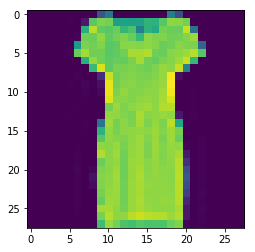

Target: 3
Name: Dress


In [6]:
IMAGE_INDX = 20

print('Image:')
plt.figure(figsize=[4, 4])
plt.imshow(fashion_dataset.data['train'][IMAGE_INDX].reshape(-1, 28))
plt.show()

print('Target:', fashion_dataset.target['train'][IMAGE_INDX])
print('Name:', fashion_dataset.feature_names[fashion_dataset.target['train'][IMAGE_INDX]])

Размерность данных

In [8]:
fashion_dataset.data['train'].shape, fashion_dataset.data['test'].shape

((60000, 784), (10000, 784))

In [9]:
fashion_dataset.target['train'].shape, fashion_dataset.target['test'].shape

((60000,), (10000,))

Обучающее и тестовое подмножества

In [18]:
X_train_, X_test, y_train_, y_test = *fashion_dataset.data.values(), *fashion_dataset.target.values()

# Уменьшение количества элементов обучающего множества
X_train = X_train_[:10000]
y_train = y_train_[:10000]

# Уменьшение размера изображений
# X_train = X_train.reshape(-1, 28, 28)[:, ::2, ::2].reshape(-1, 14*14)

Обучения классификатора

In [23]:
model = SVC(**{'C': 10, 'kernel': 'poly', 'gamma': 'scale'})
model.fit(X_train, y_train)
model.score(X_test, y_test)

0.8403

Формирование признаков посредством кластеризации

In [28]:
tick = time.time()
cluster_model = KMeans(n_clusters=50, random_state=12345)
cluster_model.fit(X_train)
print("Time =", time.time() - tick)

Time = 17.803611755371094


In [29]:
# Расстояние до центров кластеров
cluster_model.transform(X_train)[:1]

array([[1638.36685177, 3167.1586653 , 3371.68461228, 3320.57426125,
        3116.95509523, 2990.95933443, 2980.24955544, 2713.16184723,
        3033.91991755, 3640.00642812, 2520.02964857, 1573.24232359,
        3537.09312791, 2303.26334771, 2953.22060789, 2903.95932682,
        3635.22392074, 3195.11522277, 3460.4623643 , 3111.60081264,
        3033.07544467, 3374.52067769, 2154.17624631, 1466.50063478,
        2745.81835146, 3105.71400484, 2766.34169949, 2796.00726895,
        3363.75889528, 3002.48177143, 2150.56273006, 3440.51314699,
        2292.53162949, 3179.91245307, 3227.1842621 , 2549.51574402,
        3471.65813045, 3650.41596942, 2231.29598928, 2471.25912943,
        3144.53122967, 2800.30863973, 1823.15974771, 3017.88517274,
        3193.71810988, 2208.62261849, 3412.37618371, 3210.23760917,
        3151.70394582, 3393.41880773]])

In [30]:
cluster_model.transform(X_train).shape

(10000, 50)

In [31]:
# Предсказание кластеров
print(np.argmin(cluster_model.transform(X_train), axis=1)[:5])
print(cluster_model.predict(X_train[:5]))

[23 12 40 17  3]
[23 12 40 17  3]


Классификатор с новым наборам признаков

In [32]:
tick = time.time()
model = SVC(**{'C':10, 'kernel':'poly', 'gamma': 'scale'})
model.fit(cluster_model.transform(X_train), y_train)
print("Time =", time.time() - tick)
model.score(cluster_model.transform(X_test), y_test)

Time = 27.082659244537354


0.8432

Реализация посредством `Pipeline`

In [33]:
tick = time.time()
pipeline = Pipeline([
    ("cluster_model", KMeans(n_clusters=50, random_state=12345)),
    ("classifier", SVC(**{'C':10, 'kernel': 'poly', 'gamma': 'scale'})),
])
pipeline.fit(X_train, y_train)
print("Time =", time.time() - tick)
pipeline.score(X_test, y_test)

Time = 45.12840986251831


0.8432

## Обучение с частичным привлечением учителя

In [ ]:
# TODO:
# 1. Взять первые 50 наблюдений
# 2. Обучить модель и вывести качества классификации
# 3. Кластеризовать данных на 50 кластеров
# 4. Найти ближайшие наблюдения к каждому центройду кластера
# 5. Отобразить найденные изображения
# 6. Для найденных изображений вручную назначить класс
# 7. Обучить модель на размеченных данных из п.6 и вести качество классификации

##  Источники

Hands-on Machine Learning with Scikit-Learn, Keras, and TensorFlow by Aurélien Géron